In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# 1) Importations

In [2]:
%pylab inline
import os
import math
import time
import pickle
import re
import itertools
import random

import scipy
import pandas as pd
import seaborn as sns
from sklearn import model_selection, naive_bayes, decomposition, ensemble, multiclass, tree, metrics, preprocessing, svm, linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from bs4 import BeautifulSoup
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer 

Populating the interactive namespace from numpy and matplotlib
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\simon\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 2) Functions

In [3]:
def count_tags(data):
    count_df = pd.Series(data.loc[:, tags_features].squeeze().values.ravel()).value_counts()
    ct_df = pd.DataFrame({'Tag': count_df.index,
                                  'Count': count_df.values,
                                  'Prcentage (%)': (100 * (count_df / count_df.sum())).values})
    return ct_df

In [4]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        string_out = " ".join([feature_names[i] + " ({:.0f}) ".format(topic[i]) for i in topic.argsort()[:-no_top_words - 1:-1]])
        print(string_out)

In [5]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    # Get tag first letter
    tag = nltk.pos_tag([word])[0][1][0].upper()
    # Create dict of relevant tags
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    # Return relevant tag otherwise Noun
    return tag_dict.get(tag, wordnet.NOUN)

In [6]:
def body_to_words(raw_body):
    """
    Function to convert a raw body to a string of words
    The input is a single string (a raw body string), and the output is a single string (a preprocessed body)
    """
    # 1. Remove HTML
    body_text = BeautifulSoup(raw_body, "lxml").get_text() 
    #
    # 2. Remove non-letters non-numbers      
    letters_numbers_only = re.sub("[^a-zA-Z0-9#+]", " ", body_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_numbers_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Lemmatize words
    lemmatizer = WordNetLemmatizer()
    lemmatize_meaningful_words = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in meaningful_words]
    #
    # 7. Join the words back into one string separated by space, and return the result.
    return( " ".join( meaningful_words ))   

In [7]:
def text_processing(raw_text):
    """
    Function to convert a raw text to a string of words
    The input is a single string (a raw body string), and the output is a single string (a preprocessed body)
    """
    # 1. Remove HTML
    striped_text = BeautifulSoup(raw_text, "lxml").get_text() 
    #
    # 2. Remove non-letters non-numbers      
    letters_numbers_only = re.sub("[^a-zA-Z0-9#+]", " ", striped_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_numbers_only.lower()
    
    return words

In [8]:
def text_processing_stop_words(raw_text):
    """
    Function to convert a raw text to a string of words
    The input is a single string (a raw body string), and the output is a single string (a preprocessed body)
    """
    # 1. Remove HTML
    striped_text = BeautifulSoup(raw_text, "lxml").get_text() 
    #
    # 2. Remove non-letters non-numbers      
    letters_numbers_only = re.sub("[^a-zA-Z0-9#+]", " ", striped_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_numbers_only.lower().split()
    # 4. In Python, searching a set is much faster than searching a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]  
    
    return meaningful_words

In [9]:
def get_trusted_tag_predictions(df, threshold):
    """
    Take a dataframe of predicted tags probabilities as input
    Rows can be just ones and zeros (decision tree classifier), if not only keep predictions with at least 80% probability,
        turn those into ones and set the remanining probabilities to zero
    """
    df[df < threshold] = 0
    df[df >= threshold] = 1
    # Convert to int
    df = df.astype('int64')
    return df

In [10]:
def build_output(row):
    """
    Take a row of predicted tags probabilities and output the corresponding string of tags
    Take 5 tags at most, 5 with best classifier accuracy score if more than 5 tags are predicted by the classifiers
    """
    # Turn row into boolean
    row_bool = row.astype(bool)
    # Get predicted tags from columns names
    pred_tags = test_predictions_df.columns.values[row_bool]

    # How many tags have been predicted ?
    n_pred_tags = len(pred_tags)
    # If more than 5, need to sort
    if n_pred_tags > 5 :
        # Get accuracy related to predicted tags
        accuracies = np.array(true_positive_rates)[row_bool]
        # Sort to get 5 best predictions scores
        sorting_array = np.argsort(- accuracies)
        # Retrieve associated tags
        out_tags = pred_tags[sorting_array][:5]
    elif n_pred_tags == 0:
        # Predict most regular tag
        out_tags = np.array(popular_tags[0])
    else:
        out_tags = pred_tags
    
    
    if n_pred_tags > 1:
        out_string = "/".join(out_tags.tolist())
    elif n_pred_tags == 1:
        out_string = out_tags.tolist()[0]
    else:
        out_string = out_tags.tolist()
    
    return out_string

In [11]:
def get_most_probable_tags(row, selected_tags):
    """
    Take a row of predicted tags probabilities and output the corresponding string of tags
    Take 5 tags at most, 5 with best classifier accuracy score if more than 5 tags are predicted by the classifiers
    """
    # Sort probabilities
    probs = row.sort_values(ascending=False)

    # How many tags have been predicted ?
    n_pred_tags = len(probs[probs > 0])
    # If at least 5, take 5 firsts
    if n_pred_tags >= 5 :
        # Retrieve associated tags
        out_tags = probs[:5].index.values
    elif n_pred_tags == 0:
        # Predict most regular tag
        out_tags = np.array(selected_tags[0])
    else:
        out_tags = probs[:n_pred_tags].index.values

    # Output string
    if n_pred_tags > 1:
        out_string = "/".join(out_tags.tolist())
    elif n_pred_tags == 1:
        out_string = out_tags.tolist()[0]
    else:
        out_string = out_tags.tolist()
    
    return out_string

In [12]:
def local_accuracy(row):
    """
    Input is string of tags separated with '/'
    Input is turned into arrays of lists of tags
    Compute an accuracy score specific to the number of tags of the question and shrink it to a 1-based value
    Output average.
    If the number of predicted tags is greater than the number of true tags, score will be limited to 1.
    """
    # Get lists of tags
    y_true = row.True_Tags.split("/")
    y_pred = row.Predicted_Tags.split("/")
    # Compute difference
    diff = np.setdiff1d(y_true, y_pred)
    len_diff = len(y_true) - len(diff)
    score_entry = len_diff / len(y_true)
    # Return local score
    return score_entry

In [13]:
def pick_dump(obj_name, file_name):
    """ Save with pickle"""
    with open(file_name + '.pickle', 'wb') as file:
        pickle.dump(obj_name, file, protocol=pickle.HIGHEST_PROTOCOL)
    
def pick_load(file_name):
    """ Load with pickle"""
    with open(file_name + '.pickle', 'rb') as file:
        obj = pickle.load(file)
    return obj

In [14]:
def create_binary_target_df(selected_tags, data_set):
    """
    Use selected tags and build a matrix of ones and zeros (but not in sparse format) indicating what tags are related
    to each question 
    """
    tags_features = ['Tag_1', 'Tag_2', 'Tag_3', 'Tag_4', 'Tag_5']
    print("Computing binary target dataframe for %i selected tags" % selected_tags.shape[0])
    # Creating numpy array for faster computation
    temp_array = np.zeros((data_set.shape[0], selected_tags.shape[0]))
    # Loop over every selected tag
    for i, tag in zip(range(temp_array.shape[1]), selected_tags.values):
        # Find if tag countained in question's tags
        temp_array[:, i] = np.sum(data_set.loc[:, tags_features] == tag, axis=1)

    # Limiting array values to 0 and 1
    temp_array[temp_array > 1] = 1
    # Converting numpy array to pandas dataframe
    target_binary = pd.DataFrame(temp_array, columns=selected_tags, dtype='int64')

    return target_binary

In [15]:
def data_preprocessing_kg(data):
    """
    Function preparing data for unsupervised and supervised learning.
    Input is data as pandas dataframe.
    Output is resulting sparse matrix.
    """
    
    print("Cleaning Body text")
    # Apply treatment to body
    # Create clean body df
    body_words_clean = pd.DataFrame(columns=['body_words'])
    # Apply text processing to clean body df
    body_words_clean['body_words'] = data.Body.apply(text_processing)

    print("Cleaning Title text")
    # Apply treatment to title
    # Create clean title df
    title_words_clean = pd.DataFrame(columns=['title_words'])
    # Apply text processing to clean title df
    title_words_clean['title_words'] = data.Title.apply(text_processing)

    # Initialise Vectorizer to create binary bag of words (1 if the word is present in the document)
    vectorizer_kag = CountVectorizer(analyzer="word", tokenizer=None, preprocessor=None, stop_words=None, binary=True) 

    print("Vectorizing body and title into bag of words")
    # Vectorise our clean body and title words
    body_words_features = vectorizer_kag.fit_transform(body_words_clean.body_words)
    title_words_features = vectorizer_kag.fit_transform(title_words_clean.title_words)

    print("Body vectorized of shape (%i, %i) and Title vectorized of shape (%i, %i)" % (body_words_features.shape[0],
                                                                                        body_words_features.shape[1],
                                                                                        title_words_features.shape[0],
                                                                                        title_words_features.shape[1]))
    
    # Drop features with less than N occurences*
    min_feat_occ = 20
    print("Droping features with less than %i occurences" % min_feat_occ)
    
    # For body
    words_counts_body = body_words_features.sum(axis=0)
    indices = np.where(words_counts_body >= min_feat_occ)[1]
    body_words_features_threshold = body_words_features.tocsc()[:,indices]
    
    # For title
    words_counts_title = title_words_features.sum(axis=0)
    indices = np.where(words_counts_title >= 20)[1]
    title_words_features_threshold = title_words_features.tocsc()[:,indices]

    print("Body vectorized of shape (%i, %i) and Title vectorized of shape (%i, %i)" % (body_words_features_threshold.shape[0],
                                                                                        body_words_features_threshold.shape[1],
                                                                                        title_words_features_threshold.shape[0],
                                                                                        title_words_features_threshold.shape[1]))

    # Combine body and text features
    words_features = scipy.sparse.hstack((body_words_features_threshold, title_words_features_threshold))
    print("Final features matrix size : ", words_features.shape)
    
    return words_features, vectorizer_kag

In [16]:
def get_enough_frequent_tags(row, min_frequency, most_frequent_tag):
    """
    Return the tags most frequently associated to the lda topics, if frequency is above certain threshold.
    If no tags over min frequency threshold : attribute most frequent tag
    """
    # Sort row
    sorted_row = row.sort_values(ascending=False)
    # Test if at least one tag over min frequency threshold
    if sorted_row[0] >= min_frequency:
        acceptable_values = sorted_row[sorted_row >= min_frequency].index.values
        if len(acceptable_values) > 5 :
            output = acceptable_values[:5]
        else:
            output = acceptable_values
    # else return most frequent tag
    else:
        output = [most_frequent_tag]
    
    return output

In [17]:
def get_scores(truth_pred_comparison_df, unique_tags_serie, verbose=True):
    """
    Function that outputs lcoal metric and f1-score
    """
    ### Local hand-made metric ###
    truth_pred_comparison_df['local_metric'] = truth_pred_comparison_df.apply(local_accuracy, axis=1)
    local_metric = truth_pred_comparison_df.local_metric.mean()
    
    ### Calculating f1_score ###

    # Split tags and make tags lists for multilabel binarizer to work with
    y_true_splitted = truth_pred_comparison_df.True_Tags.apply(lambda x: x.split("/"))
    # From dataframe to series
    y_pred_splitted = truth_pred_comparison_df.Predicted_Tags.apply(lambda x: x.split("/"))
    
    # Fit test true tags
    binarizer = preprocessing.MultiLabelBinarizer().fit(unique_tags_serie)

    # Check what have been learnt by the binarizer
    
    # Compute f1_score average on samples because of multi-label multi-class classification
    f1_score = metrics.f1_score(binarizer.transform(y_true_splitted),
                                binarizer.transform(y_pred_splitted),
                                average='samples')

    if verbose:
        print("Average hand-made local accuracy score : %.2f" % local_metric)
        print("F1 Score : %.3f" % f1_score)
        print("sample of binarizer vocabulary", binarizer.classes_)
    return local_metric, f1_score

# 3) Gathering data

Loading main dataframe, already cleant

In [ ]:
# Getting current path
path = os.getcwd()
try :
    print("Loading clean questions full dataset")
    data_raw = pd.read_csv(path + "/data/data_questions_clean.csv", sep=',')
    print("Clean questions full dataset loaded")
except :
    print("The 'data_questions_clean.csv' file is not in the 'data' folder")

### Loading pre-processed dataframe in order to save cleaning computational time

In [18]:
preclean = True
if preclean:
    # Getting current path
    path = os.getcwd()
    try :
        print("Loading pre-processed clean questions full dataset")
        data_raw = pd.read_csv(path + "/data/data_questions_clean_processed.csv", sep=',')
        print("pre-processed clean questions full dataset loaded")
    except :
        print("The 'data_questions_clean_processed.csv' file is not in the 'data' folder")

Loading pre-processed clean questions full dataset
pre-processed clean questions full dataset loaded


Having a look at our data

In [ ]:
data_raw.head()

# 4) Cleaning / Exploring

## 4.1) Cleaning

Just in case

In [19]:
tags_features = ['Tag_1', 'Tag_2', 'Tag_3', 'Tag_4', 'Tag_5']

In [20]:
print("Initial shape : ", data_raw.shape)
data_raw = data_raw.dropna(subset=['Tags'])
print("New shape : ", data_raw.shape)
try:
    data_raw = data_raw.dropna(subset=['New_Tags_syn'])
    print("New shape : ", data_raw.shape)
except KeyError:
    pass
try:
    data_raw = data_raw.dropna(subset=tags_features, how='all')
    print("New shape : ", data_raw.shape)
except KeyError:
    pass

Initial shape :  (169430, 33)
New shape :  (169430, 33)
New shape :  (169430, 33)
New shape :  (169430, 33)


## 4.2) Exploring reminder

Before removing synonyms :

In [21]:
temp_list = [x.split('/') for x in data_raw.New_Tags_syn.values.tolist()]
tags_list = [y for x in temp_list for y in x]
unique_tags_syn = list(set(tags_list))
print("Total of %i unique Tags" % len(unique_tags_syn))

Total of 13971 unique Tags


Counting Tags in Dataframe in order to find most popular Tags

In [22]:
count_tags_df = count_tags(data_raw)
count_tags_df.head()

,Tag,Count,Prcentage (%)
0,c#,23650,4.818477
1,.net,15082,3.072823
2,java,12107,2.466693
3,asp.net,11082,2.257859
4,javascript,8486,1.728947


In [23]:
most_popular_tag = count_tags_df.Tag[0]

Get all tags to train binarizers for computing f1-score

In [24]:
unique_tags_serie = pd.Series(unique_tags_syn).apply(lambda x: [x])

# 5) First modelisation approach

Naive modelisation looking at rough data as explanatory features

In [ ]:
feature = 'Body'

Train / Test split

Taking sample

In [ ]:
X_train_first = data_raw.loc[:, feature].iloc[:10000]
X_test_first = data_raw.loc[:, feature].iloc[10000:11000]
y_train_first = data_raw.New_Tags_syn.iloc[:10000]
y_test_first = data_raw.New_Tags_syn.iloc[10000:11000]

Creating bag of words

In [ ]:
count_vect = CountVectorizer()
X_train_first_counts = count_vect.fit_transform(X_train_first)
X_train_first_counts.shape

Looking at vocabulary learnt by the algorithm

In [ ]:
count_vect.vocabulary_

Convert bag of words into Tf-idf matrices

In [ ]:
tfidf_transformer = TfidfTransformer()
X_train_first_tfidf = tfidf_transformer.fit_transform(X_train_first_counts)
X_train_first_tfidf.shape

In [ ]:
print(X_train_first_tfidf[0])

Train naive bayes classifier

In [ ]:
clf = naive_bayes.MultinomialNB().fit(X_train_first_counts, y_train_first)

Predict test data

In [ ]:
X_test_first_counts = count_vect.transform(X_test_first)
X_test_first_tfidf = tfidf_transformer.transform(X_test_first_counts)

predicted = clf.predict(X_test_first_tfidf)
y_pred_first = pd.Series(predicted)
# Transform predicted array to pandas serie of lists of predicted tags in order to train binarizer
y_pred_first_serie = y_pred_first.apply(lambda x: x.split("/"))
# Transform true pandas serie to pandas serie of lists of predicted tags in order to train binarizer
y_test_first_serie = y_test_first.apply(lambda x: x.split("/"))
# Transform true pandas serie to pandas serie of lists of predicted tags in order to train binarizer
y_train_first_serie = y_train_first.apply(lambda x: x.split("/"))

Compare truth and prediction, compute local metric

In [ ]:
y_pred_first.index = y_test_first.index
comparison_df_naive = pd.concat((y_pred_first, y_test_first), axis=1)
comparison_df_naive.columns = ['Predicted_Tags', 'True_Tags']
# display
display(comparison_df_naive)

In [ ]:
get_scores(comparison_df_naive, unique_tags_serie)

As expected this naive classifier outputs poor results

# 6) Text cleaning - data preprocessing

If needed : clean main text feature (quite long)

In [ ]:
# data_raw['clean_title_body'] = data_raw.loc[:, 'TitleBody'].apply(body_to_words)

Let's use a reasonnable train/test size for our tests

#### Selecting Train et Test sets

In [25]:
length_train = 30000
length_test = 8000
# Get random data of train + test size
data_train_test = data_raw.sample(length_train + length_test, random_state=0)
# In those random data slice into train and test datasets
data_train = data_train_test.iloc[:length_train, :]
data_test = data_train_test.iloc[length_train:, :]

### Text Processing

"Advanced" text processing

In [26]:
# In order to save computational time : not cleaning everytime
if preclean:
    feature = 'clean_title_body'
    X_train_adv = data_train.loc[:, feature]
    X_test_adv = data_test.loc[:, feature]    
else: # Excessively time consuming
    # Apply advanced text processing
    feature = 'TitleBody'
    print("Training set processing")
    X_train_adv = data_train.loc[:, feature].apply(body_to_words)
    print("Testing set processing")
    X_test_adv = data_test.loc[:, feature].apply(body_to_words)

y_train = data_train.New_Tags_syn
y_test = data_test.New_Tags_syn

Creating bag of words

In [27]:
print("Creating the bag of words...\n")

# Initialize the "CountVectorizer" object, which is scikit-learn's bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 

# fit_transform() does two functions: First, it fits the model and learns the vocabulary; second,
# it transforms our training data into feature vectors. The input to fit_transform should be a list of strings.
train_data_features_adv = vectorizer.fit_transform(X_train_adv)
test_data_features_adv = vectorizer.fit_transform(X_test_adv)

# Numpy arrays are easy to work with, so convert the result to an array
# train_data_features_arr = train_data_features.toarray()
# test_data_features_arr = test_data_features.toarray()

Creating the bag of words...



Small interlude : looking at our words features

In [86]:
title_clean_serie = data_raw.loc[:, 'Title'].apply(text_processing_stop_words)
Title_clean_limited = pd.DataFrame(title_clean_serie)

In [87]:
one_title_list = [item for sublist in Title_clean_limited.Title.ravel() for item in sublist]
title_words_clean = pd.Series(one_title_list)
titlecounts = title_words_clean.value_counts()

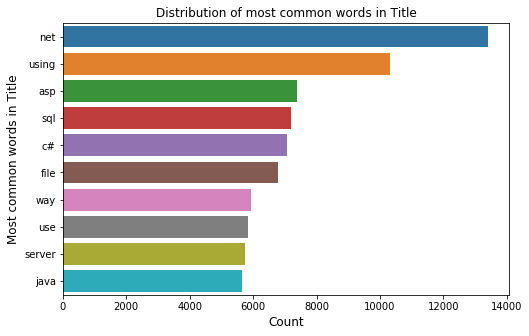

In [103]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(y=titlecounts[:10].index.values, x=titlecounts[:10].values, orient='h')
# ax.set_xticklabels(titlecounts[:10].index.values, fontsize=12)
ax.set_ylabel("Most common words in Title", fontsize=12)
ax.set_xlabel("Count", fontsize=12)
ax.set_title("Distribution of most common words in Title", fontsize=12);

In [89]:
body_clean_serie = data_raw.loc[:, 'Body'].apply(text_processing_stop_words)
Body_clean_limited = pd.DataFrame(body_clean_serie)
one_body_list = [item for sublist in Body_clean_limited.Body.ravel() for item in sublist]
body_words_clean = pd.Series(one_body_list)
bodycounts = body_words_clean.value_counts()

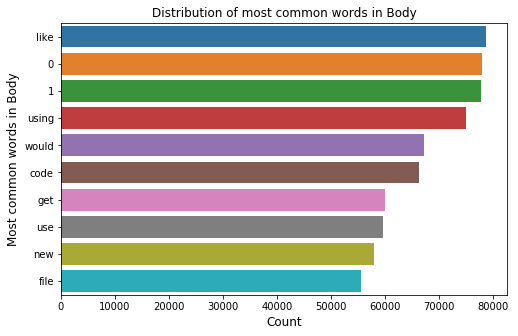

In [104]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(y=bodycounts[:10].index.values, x=bodycounts[:10].values, orient='h')
# ax.set_xticklabels(titlecounts[:10].index.values, fontsize=12)
ax.set_ylabel("Most common words in Body", fontsize=12)
ax.set_xlabel("Count", fontsize=12)
ax.set_title("Distribution of most common words in Body", fontsize=12);

"Limited" text processing

In [28]:
words_features_train_test, vectorizer = data_preprocessing_kg(data_train_test)

Cleaning Body text
Cleaning Title text
Vectorizing body and title into bag of words
Body vectorized of shape (38000, 103901) and Title vectorized of shape (38000, 15927)
Droping features with less than 20 occurences
Body vectorized of shape (38000, 6712) and Title vectorized of shape (38000, 1766)
Final features matrix size :  (38000, 8478)


Get Bag of Words Train and Test dataset

In [29]:
train_data_features_lim = words_features_train_test[:length_train, :]
test_data_features_lim = words_features_train_test[length_train:, :]

## Select text processing method

In [30]:
text_processing_type = 'limited'
# Select prOcessed data
if text_processing_type == 'advanced':
    train_data_features = train_data_features_adv
    test_data_features = test_data_features_adv
elif text_processing_type == 'limited':
    train_data_features = train_data_features_lim
    test_data_features = test_data_features_lim
else:
    raise IndexError

## Select Counts bag of words or Tf-idf matrices

In [31]:
tfidf = False
if tfidf:
    tfidf_transformer = TfidfTransformer()
    X_train = tfidf_transformer.fit_transform(train_data_features)
    X_test = tfidf_transformer.transform(test_data_features)
else:
    X_train = train_data_features
    X_test = test_data_features

In [32]:
print(X_train.shape, X_test.shape)

(30000, 8478) (8000, 8478)


# 7) Classifiers - Supervised learning

## 7.1) First Modelisation : Supervised classification with different classifiers

In [ ]:
print(X_train.shape, y_train.shape)
if X_train.shape[0] != y_train.shape[0]:
    raise IndexError

In [ ]:
# Take a look at the words in the vocabulary
vocab = vectorizer.get_feature_names()
print(random.sample(vocab, 20))

### 7.1.1) Train naive bayes classifier

In [ ]:
naive_bayes_clf = naive_bayes.MultinomialNB()
naive_bayes_ovr = multiclass.OneVsRestClassifier(naive_bayes_clf, n_jobs=-1)
print("Training on train dataset")
naive_bayes_clf = naive_bayes_clf.fit(X_train, y_train)

In [ ]:
# Use the naive bayes to make tags label predictions
print("Predicting for test dataset")
result_nb = naive_bayes_clf.predict(X_test)

In [ ]:
# Copy the results to a pandas dataframe with a "tags" column
output_nb = pd.DataFrame(result_nb, index=y_test.index, columns=['pred_tags'])

# Concatenate truth and prediction
comparison_df_nb = pd.concat((output_nb, y_test), axis=1)
comparison_df_nb.columns = ['Predicted_Tags', 'True_Tags']

In [ ]:
get_scores(comparison_df_nb, unique_tags_serie);

Naive Bayes classifier accomplish little score

#### Train SVM classifier

In [33]:
svm_clf = svm.LinearSVC()
svmm = multiclass.OneVsRestClassifier(svm_clf, n_jobs=-1)
print("Training on train dataset")
svm_clf = svm_clf.fit(train_data_features, y_train)

Training on train dataset


In [34]:
# Use the linear SVM to make tags label predictions
result_svm = svm_clf.predict(test_data_features)

In [35]:
# Copy the results to a pandas dataframe with a "tags" column
output_svm = pd.DataFrame(result_svm, index=y_test.index, columns=['pred_tags'])

# Concatenate truth and prediction
comparison_df_svm = pd.concat((output_svm, y_test), axis=1)
comparison_df_svm.columns = ['Predicted_Tags', 'True_Tags']

In [36]:
get_scores(comparison_df_svm, unique_tags_serie)

Average hand-made local accuracy score : 0.20
F1 Score : 0.224
sample of binarizer vocabulary ['.emf' '.htaccess' '.htpasswd' ... 'zune' 'zx81' 'zxspectrum']


(0.19839374999999954, 0.2239673611111111)

SVM classifier accomplish a little bit more than naive bayes

#### Train Logistic Regression classifier

In [33]:
# reg_log_clf = linear_model.LogisticRegression()
# reg_log_ovr = multiclass.OneVsRestClassifier(reg_log_clf, n_jobs=-1)
# print("Training on train dataset")
# reg_log_clf = reg_log_clf.fit(train_data_features, y_train)

Training on train dataset


In [34]:
# # Use the logistic regression to make tags label predictions
# result_reg_log = reg_log_clf.predict(test_data_features)

In [35]:
# # Copy the results to a pandas dataframe with a "tags" column
# output_reg_log = pd.DataFrame(result_reg_log, index=y_test.index, columns=['pred_tags'])

# # Concatenate truth and prediction
# comparison_df_reg_log = pd.concat((output_reg_log, y_test), axis=1)
# comparison_df_reg_log.columns = ['Predicted_Tags', 'True_Tags']

In [36]:
# get_scores(comparison_df_reg_log, unique_tags_serie)

Average hand-made local accuracy score : 0.09
F1 Score : 0.107
sample of binarizer vocabulary ['.emf' '.htaccess' '.htpasswd' ... 'zune' 'zx81' 'zxspectrum']


(0.09283333333333331, 0.10661904761904763)

Logistic Regression classifier takes too long to run to be considered as a viable option

#### Train Random Forest Classifier : Can't train because of memory

In [ ]:
# print("Training the random forest...")

# # Initialize a Random Forest classifier with 100 trees
# forest = ensemble.RandomForestClassifier(n_estimators = 100) 

# # Fit the forest to the training set, using the bag of words as features and the tags labels as the response variable
# # This may take a few minutes to run
# forest = forest.fit(X_train, y_train)

Predict on Test data

In [ ]:
# # Use the random forest to make tags label predictions
# result_forest = forest.predict(y_test)

In [ ]:
# # Copy the results to a pandas dataframe with a "tags" column
# output_forest = pd.DataFrame(result_forest, index=y_test.index, columns=['pred_tags'])

# # Concatenate truth and prediction
# comparison_df_forest = pd.concat((output_forest, y_test), axis=1)
# comparison_df_forest.columns = ['Predicted_Tags', 'True_Tags']

In [ ]:
# get_scores(output_forest, unique_tags_serie)

Random Forest classifier takes too much memory to run to be considered as a viable option

# 8) Unsupervised approach - LatentDirichletAllocation

#### Train LDA

In [ ]:
no_topics = 100

# Run LDA
lda = decomposition.LatentDirichletAllocation(n_components=no_topics, 
                                              max_iter=5, 
                                              learning_method='online', 
                                              learning_offset=50.,
                                              random_state=0)
lda.fit(X_train)

In [ ]:
no_top_words = 15
display_topics(lda, vectorizer.get_feature_names(), no_top_words)

#### Transform train features with lda model to output most probable lda topics for each question

In [ ]:
train_feat_transformed = lda.transform(X_train)

Distribution of max probability that a question belongs to a lda topic

To be used to select a threshold for a question to belong to a topic

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
sns.distplot(np.amax(train_feat_transformed, axis=1), kde=False)
ax.set_xlabel("Topic affiliation probability", fontsize=12)
ax.set_ylabel("Count", fontsize=12);

Get lda topics associated with questions.

First only most probable topic, then all topics over a threshold of probability

In [ ]:
max_most_probable_topics = []
for i in range(0, len(train_feat_transformed)):
    topic_max_proba = np.argsort(-train_feat_transformed[i,:])[0]
    max_most_probable_topics.append(topic_max_proba)

In [ ]:
topics, counts = np.unique(max_most_probable_topics, return_counts=True)
main_topic = topics[np.argsort(-counts)][0]
# main_topic_to_remove = topics[np.argsort(-counts)][0]

Remove main topic from the equation

In [ ]:
# train_feat_transformed_red = np.delete(train_feat_transformed, main_topic_to_remove, axis=1)

In [ ]:
# max_most_probable_topics = []
# for i in range(0, len(train_feat_transformed_red)):
#     topic_max_proba = np.argsort(-train_feat_transformed_red[i,:])[0]
#     max_most_probable_topics.append(topic_max_proba)

In [ ]:
# topics, counts = np.unique(max_most_probable_topics, return_counts=True)
# main_topic = topics[np.argsort(-counts)][0]

Apply threshold

In [ ]:
min_proba_topic = 0
most_probable_topics = []
for i in range(0, len(train_feat_transformed)):
    indexes_sort = np.argsort(-train_feat_transformed[i,:])
    max_proba = train_feat_transformed[i,:][indexes_sort][0]
    topic_max_proba = indexes_sort[0]
    if max_proba >= min_proba_topic:
        most_probable_topics.append(topic_max_proba)
    else:
        most_probable_topics.append(main_topic)

Looking at lda topics distribution among questions

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
sns.distplot(most_probable_topics, kde=False)
ax.set_xlabel("LDA Topic", fontsize=12)
ax.set_ylabel("Questions associated to topic", fontsize=12);

Associating questions tags to the related most probable topic

In [ ]:
# Initialize matrix of size (n_topics, n_unique_tags)
tags_topics = np.zeros((no_topics, len(unique_tags_syn)))

In [ ]:
test_tags_topics_df = pd.DataFrame(tags_topics, columns=unique_tags_syn, dtype='int64')
for i, topic in enumerate(most_probable_topics):
    for tag in y_train.iloc[i].split("/"):
        test_tags_topics_df.loc[topic, tag] += 1
#     if (i % 10000) == 0 :
#         print("%i / %i" % (i, len(most_probable_topics)))

In [ ]:
min_frequency_tag = 20
main_tags_by_topics = test_tags_topics_df.apply(get_enough_frequent_tags, args=(min_frequency_tag,
                                                                                most_popular_tag), axis=1)

In [ ]:
tempodf = pd.DataFrame()
tempodf['LDA Topic'] = main_tags_by_topics.index.values
tempodf['Tags'] = main_tags_by_topics
tempodf

#### On test dataframe

Transform test data through LDA

In [ ]:
test_feat_transformed = lda.transform(X_test)

Remove main topic like we did for train data

In [ ]:
# test_feat_transformed = np.delete(test_feat_transformed, main_topic_to_remove, axis=1)

Look to which LDA topic test questions are most likely to correspond

A probability threshold may make sense here

In [ ]:
min_proba_topic_test = 0
most_probable_topics_test = []
max_proba_test = []
for i in range(0, len(test_feat_transformed)):
    indexes_sort = np.argsort(-test_feat_transformed[i,:])
    max_proba = test_feat_transformed[i,:][indexes_sort][0]
    max_proba_test.append(max_proba)
    topic_max_proba = indexes_sort[0]
    if max_proba >= min_proba_topic_test:
        most_probable_topics_test.append(topic_max_proba)
    else:
        most_probable_topics_test.append(main_topic)

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
sns.distplot(most_probable_topics_test, kde=False)
ax.set_xlabel("LDA Topic", fontsize=12)
ax.set_ylabel("Questions associated to topic", fontsize=12);
ax.set_title("Topics distribution among test questions", fontsize=12);

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
sns.distplot(max_proba_test, kde=False)
ax.set_xlabel("Topic affiliation probability", fontsize=12)
ax.set_ylabel("Count", fontsize=12);
ax.set_title("Topics max probability attribution distribution for test questions");

Notice that most test questions are not surely associated to topics

In [ ]:
mean_max_probas_test = np.mean(max_proba_test)
median_max_probas_test = np.median(max_proba_test)
print("Mean of max probabilities of test questions belonging to topics : %.2f, median : %.2f" % (mean_max_probas_test,
                                                                                                 median_max_probas_test))

Attribute topics tags to questions

In [ ]:
y_pred_lda = pd.DataFrame(most_probable_topics_test, index=y_test.index, columns=['topics'])

In [ ]:
y_pred_lda['pred_tags'] = y_pred_lda.topics.apply(lambda x: main_tags_by_topics[x])
y_pred_lda = y_pred_lda.drop(labels=['topics'], axis=1)

Compare true target to prediction

In [ ]:
comparison_df_lda = pd.concat((y_pred_lda, y_test), axis=1)
comparison_df_lda.columns = ['Predicted_Tags', 'True_Tags']
# '/' join predicted tags
comparison_df_lda['Predicted_Tags'] = comparison_df_lda['Predicted_Tags'].apply(lambda x: "/".join(x))
display(comparison_df_lda)

In [ ]:
comparison_df_lda.sample(10)

In [ ]:
get_scores(comparison_df_lda, unique_tags_serie);

#### SCORING GRID, With hand made metric and f1-score
**Text processing - Train size - TF-IDF - Test size - N topics - threshold topics - score - f1_score**

* Advanced - 100000 - 20000 - False - 100 - 0 - 0.12 - 0.088
* Advanced - 100000 - 20000 - False - 50 - 0 - 0.13 - 0.094
* Advanced - 100000 - 20000 - False - 50 - 0 - 0.12 - 0.081 -> main topic removed
* Advanced - 100000 - 20000 - False - 20 - 0 - 0.14 - 0.094
* Advanced - 100000 - 20000 - False - 300 - 0 - 0.11 - 0.079
* Limited - 100000 - 20000 - False - 50 - 0 - 0.17 - 0.115
* Limited - 100000 - 20000 - False - 50 - 0.3 - 0.16 - 0.112
* Advanced - 30000 - 8000 - False - 50 - 0.3 - 0.15 - 0.103
* Limited - 30000 - 8000 - True - 50 - 0.3 - 0.15 - 0.105
* Limited - 30000 - 8000 - False - 50 - 0 - 0.17 - 0.120
* Advanced - 30000 - 8000 - False - 50 - 0 - 0.14 - 0.101
* Advanced - 30000 - 8000 - True - 50 - 0 - 0.15 - 0.103
* Limited - 30000 - 8000 - False - 50 - 0 - 0.15 - 0.103
* Limited - 30000 - 8000 - False - 20 - 0 - 0.18 - 0.119

# 9) Supervised classification on words

With previous supervised learning methods comes one major issue : learning is done on chains of tags rather than on each tag individually.

Therefore accurate predictions tend to be much more difficult.

As a solution we will modify our target vector to a matrix target, and train one classifier for each vector in the matrix, corresponding to a boolean presence of absence of the tag vector.

#### Retrieve train tags with at least N occurences in the train dataset

In [72]:
# Define min volumetry
min_tag_volumetry = 20
# Retrieve training tags
count_tags_train = count_tags(data_train)
# Select training tags with minimum volumetry
sel_tags_train = count_tags_train[count_tags_train.Count >= min_tag_volumetry].Tag
print("Given our training set we selected %i Tags with at least %i occurences in the training set" % (sel_tags_train.shape[0],
                                                                                                      min_tag_volumetry))

Given our training set we selected 622 Tags with at least 20 occurences in the training set


#### Get Target vectors

Build targets vectors for one versus rest classification

In [73]:
y_train_kg = create_binary_target_df(sel_tags_train, data_train)
y_test_kg = create_binary_target_df(sel_tags_train, data_test)

Computing binary target dataframe for 622 selected tags
Computing binary target dataframe for 622 selected tags


Get target tags strings

In [74]:
y_test_kg_tags = data_test.New_Tags_syn

#### Train a classifier for each of the selected tags

In [75]:
# poly_prune_trees = pick_load(path + "/data/poly_prune_trees")

In [76]:
classifiers = []
count = 1
for tag in sel_tags_train:
    print("Training classifier for %s tag (%i / %i)" % (tag, count, len(sel_tags_train)))
#     # Retrieve tag frequency
#     get_tag_counts = count_tags_train[count_tags_train.Tag == tag].Count.values
#     # Use tag frequency to prune trees (not ok with c#)
#     depth_to_prune = np.polyval(poly_prune_trees, get_tag_counts)
#     classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
#     classifier = svm.LinearSVC(random_state=0)
#     classifier = linear_model.LogisticRegression(random_state=0)
    classifier = ensemble.RandomForestClassifier(n_estimators = 100)
    classifier.fit(X_train, y_train_kg[tag])
    classifiers.append(classifier)
    count += 1

Training classifier for c# tag (1 / 622)
Training classifier for .net tag (2 / 622)
Training classifier for java tag (3 / 622)
Training classifier for asp.net tag (4 / 622)
Training classifier for c++ tag (5 / 622)
Training classifier for javascript tag (6 / 622)
Training classifier for php tag (7 / 622)
Training classifier for python tag (8 / 622)
Training classifier for sql tag (9 / 622)
Training classifier for sql-server tag (10 / 622)
Training classifier for jquery tag (11 / 622)
Training classifier for html tag (12 / 622)
Training classifier for iphone tag (13 / 622)
Training classifier for asp.net-mvc tag (14 / 622)
Training classifier for windows tag (15 / 622)
Training classifier for mysql tag (16 / 622)
Training classifier for c-minus-minus tag (17 / 622)
Training classifier for wpf tag (18 / 622)
Training classifier for xml tag (19 / 622)
Training classifier for visual-studio tag (20 / 622)
Training classifier for database tag (21 / 622)
Training classifier for vb.net tag (22

Training classifier for pointers tag (171 / 622)
Training classifier for audio tag (172 / 622)
Training classifier for java-ee tag (173 / 622)
Training classifier for file-io tag (174 / 622)
Training classifier for plugins tag (175 / 622)
Training classifier for frameworks tag (176 / 622)
Training classifier for spring tag (177 / 622)
Training classifier for postgresql tag (178 / 622)
Training classifier for interface tag (179 / 622)
Training classifier for url tag (180 / 622)
Training classifier for rest tag (181 / 622)
Training classifier for ssl tag (182 / 622)
Training classifier for types tag (183 / 622)
Training classifier for android tag (184 / 622)
Training classifier for windows-services tag (185 / 622)
Training classifier for qt tag (186 / 622)
Training classifier for syntax tag (187 / 622)
Training classifier for resources tag (188 / 622)
Training classifier for gcc tag (189 / 622)
Training classifier for concurrency tag (190 / 622)
Training classifier for error-handling tag

Training classifier for nunit tag (336 / 622)
Training classifier for c#-3.0 tag (337 / 622)
Training classifier for tcp tag (338 / 622)
Training classifier for attributes tag (339 / 622)
Training classifier for documentation tag (340 / 622)
Training classifier for ms-office tag (341 / 622)
Training classifier for uitableview tag (342 / 622)
Training classifier for cruisecontrol.net tag (343 / 622)
Training classifier for rss tag (344 / 622)
Training classifier for colors tag (345 / 622)
Training classifier for compression tag (346 / 622)
Training classifier for timezone tag (347 / 622)
Training classifier for join tag (348 / 622)
Training classifier for mobile tag (349 / 622)
Training classifier for methods tag (350 / 622)
Training classifier for http-headers tag (351 / 622)
Training classifier for binary tag (352 / 622)
Training classifier for silverlight-2.0 tag (353 / 622)
Training classifier for haskell tag (354 / 622)
Training classifier for outlook tag (355 / 622)
Training class

Training classifier for macros tag (502 / 622)
Training classifier for scrum tag (503 / 622)
Training classifier for pinvoke tag (504 / 622)
Training classifier for exchange-server tag (505 / 622)
Training classifier for visual-sourcesafe tag (506 / 622)
Training classifier for iterator tag (507 / 622)
Training classifier for sysadmin tag (508 / 622)
Training classifier for singleton tag (509 / 622)
Training classifier for mercurial tag (510 / 622)
Training classifier for scheme tag (511 / 622)
Training classifier for x86 tag (512 / 622)
Training classifier for ip-address tag (513 / 622)
Training classifier for dynamic-data tag (514 / 622)
Training classifier for tree tag (515 / 622)
Training classifier for connection tag (516 / 622)
Training classifier for operator-overloading tag (517 / 622)
Training classifier for vmware tag (518 / 622)
Training classifier for django-forms tag (519 / 622)
Training classifier for uml tag (520 / 622)
Training classifier for db2 tag (521 / 622)
Trainin

#### Predict proba of predicting tag for each classifier based on test data

In [77]:
test_predictions = []
count = 0
zero_array = np.zeros((X_test.shape[0]))
for clf in classifiers:
    print(count, " / ", len(classifiers))
    prediction = clf.predict_proba(X_test)

    if prediction.shape[1] == 2:
        test_predictions.append(prediction[:,1])
    elif prediction.shape[1] == 1:
        test_predictions.append(zero_array)
    else:
        import pdb;pdb.set_trace()
    count += 1

0  /  622
1  /  622
2  /  622
3  /  622
4  /  622
5  /  622
6  /  622
7  /  622
8  /  622
9  /  622
10  /  622
11  /  622
12  /  622
13  /  622
14  /  622
15  /  622
16  /  622
17  /  622
18  /  622
19  /  622
20  /  622
21  /  622
22  /  622
23  /  622
24  /  622
25  /  622
26  /  622
27  /  622
28  /  622
29  /  622
30  /  622
31  /  622
32  /  622
33  /  622
34  /  622
35  /  622
36  /  622
37  /  622
38  /  622
39  /  622
40  /  622
41  /  622
42  /  622
43  /  622
44  /  622
45  /  622
46  /  622
47  /  622
48  /  622
49  /  622
50  /  622
51  /  622
52  /  622
53  /  622
54  /  622
55  /  622
56  /  622
57  /  622
58  /  622
59  /  622
60  /  622
61  /  622
62  /  622
63  /  622
64  /  622
65  /  622
66  /  622
67  /  622
68  /  622
69  /  622
70  /  622
71  /  622
72  /  622
73  /  622
74  /  622
75  /  622
76  /  622
77  /  622
78  /  622
79  /  622
80  /  622
81  /  622
82  /  622
83  /  622
84  /  622
85  /  622
86  /  622
87  /  622
88  /  622
89  /  622
90  /  622
91  /  62

Convert list of arrays to dataframe and keep probabilities over trusted threshold as tags predictions

In [82]:
# Convert to df
test_predictions_df = pd.DataFrame(np.array(test_predictions).T, columns=y_test_kg.columns)
# Set threshold
trusted_threshold = 0
# Map threshold
test_predictions_df_thresh = test_predictions_df.copy()
test_predictions_df_thresh[test_predictions_df_thresh < trusted_threshold] = 0
# test_predictions_df = get_trusted_tag_predictions(test_predictions_df, trusted_threshold)

#### Build Predicted tags from classifiers, if more than 5 keep the 5 first with highest probability

In [83]:
y_pred_kg = pd.Series()
y_pred_kg = test_predictions_df_thresh.apply(get_most_probable_tags, args=(sel_tags_train,), axis=1)

Concatenate predicted tags and true tags for comparison

In [84]:
y_pred_kg.index = y_test_kg_tags.index
comparison_df = pd.concat((y_pred_kg, y_test_kg_tags), axis=1)
comparison_df.columns = ['Predicted_Tags', 'True_Tags']
comparison_df['Local_Metric'] = comparison_df.apply(local_accuracy, axis=1)
display(comparison_df)

,Predicted_Tags,True_Tags,Local_Metric
27209,java/apache/c#/linux/visual-c++,vba/vb6/ide/vbe,0.000000
81096,c#/ssl/tfs/.net/c++,stored-procedures/db2,0.000000
70915,java/mysql/c#/windows/multithreading,windows/powershell/windows-server-2000,0.333333
148580,c#/ruby-on-rails/ruby/mysql/java,c-minus-minus/centos/pear/pear,0.250000
144387,java/.net/c#/winforms/user-interface,iphone/sandbox,0.000000
162593,iphone/c#/perl/java/windows,django,0.000000
126149,iphone/c#/php/java/c++,performance/perl,0.000000
34767,java/c#/c++/blackberry/java-me,mysql/join/distinct,0.000000
41950,c++/c#/java/unicode/c-minus-minus,java,1.000000
161965,c++/vim/django/linux/kernel,.net/annotations/paint,0.000000


In [85]:
get_scores(comparison_df, unique_tags_serie);

Average hand-made local accuracy score : 0.12
F1 Score : 0.084
sample of binarizer vocabulary ['.emf' '.htaccess' '.htpasswd' ... 'zune' 'zx81' 'zxspectrum']


(0.12260416666666826, 0.08356130952380952)

#### SCORING GRID, With hand made metric, with classifiers on tag with at least N occurences
**Train size - Test size - TFIDF - N occ tags - algorithm - parameter - score - f1_score**

* 50000 - 5000 - False - 50 - random forest - proba thresh 0.05 - 0.10
* 50000 - 5000 - False - 50 - random forest - proba thresh 0.1 - 0.07
* 50000 - 5000 - False - 50 - random forest - proba thresh 0.01 - 0.11 - 0.078
* 100000 - 20000 - False - 20 - Logisitic reg - proba thresh 0.01 - 0.61 - 0.419
* 100000 - 20000 - False - 20 - Logisitic reg - proba thresh 0.2 - 0.48 - 0.473
* 100000 - 20000 - False - 20 - Logisitic reg - proba thresh 0.15 - 0.5 - 0.475
* 100000 - 20000 - False - 20 - Logisitic reg - proba thresh 0.1 - 0.54 - 0.473
* 30000 - 8000 - False - 20 - Logisitic reg - proba thresh 0 - 0.55 - 0.368
* 30000 - 8000 - False - 20 - decision tree - proba thresh 0 - 0.37 - 0.377
* 30000 - 8000 - True - 20 - Logisitic reg - proba thresh 0.01 - 0.5 - 0.338
* 100000 - 20000 - False - 20 - decision tree - proba thresh 0.1 - 0.42 - 0.412 --> Trees not pruned, threshold useless
* 100000 - 20000 - False - 20 - decision tree - proba thresh 0.1 - 0.47 - 0.427 --> Trees pruned with polynom
* 100000 - 20000 - False - 20 - decision tree - proba thresh 0.15 - 0.45 - 0.437 --> Trees pruned with polynom
* 100000 - 20000 - False - 20 - decision tree - proba thresh 0.2 - 0.44 - 0.440 --> Trees pruned with polynom
* 100000 - 20000 - False - 20 - decision tree - proba thresh 0.3 - 0.42 - 0.438 --> Trees pruned with polynom

Computing small grid search on prediction trust threshold

In [ ]:
thresh = numpy.linspace(0, 1, 50)
local_metric = []
f1score = []
count=1
for threshold in thresh:
    print(count)
    # Convert to df
    test_predictions_df = pd.DataFrame(np.array(test_predictions).T, columns=y_test_kg.columns)
    # Set threshold
    trusted_threshold = threshold
    # Map threshold
    test_predictions_df_thresh = test_predictions_df.copy()
    test_predictions_df_thresh[test_predictions_df_thresh < trusted_threshold] = 0

    #### Build Predicted tags from classifiers, if more than 5 keep the 5 first with highest probability
    y_pred_kg = pd.Series()
    y_pred_kg = test_predictions_df_thresh.apply(get_most_probable_tags, args=(sel_tags_train,), axis=1)

    # Concatenate predicted tags and true tags for comparison
    y_pred_kg.index = y_test_kg_tags.index
    comparison_df = pd.concat((y_pred_kg, y_test_kg_tags), axis=1)
    comparison_df.columns = ['Predicted_Tags', 'True_Tags']

    temp_metric, temp_f1_score = get_scores(comparison_df, unique_tags_serie, verbose=False)
    local_metric.append(temp_metric)
    f1score.append(temp_f1_score)
    count+=1

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.set_style("darkgrid")
plt.plot(thresh, local_metric, label="Local Metric")
plt.plot(thresh, f1score, label="F1-Score")
ax.set_xlabel("Classifier trust prediction level", fontsize=12)
ax.set_ylabel("Metrics score", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12);

## Researches on pruning decision trees based on tag frequency

In [ ]:
loop_depths = []
for i in range(50):
    print(i)
    loop_depths.append(tree.DecisionTreeClassifier(criterion='entropy', random_state=0).fit(X_train_kg, y_train_kg['png']).tree_.max_depth)
loop_depths

In [ ]:
# tempotrees = []
# for tag in sel_tags_train[:15]:
#     print(tag)
#     tempotrees.append(tree.DecisionTreeClassifier(criterion='entropy', random_state=0).fit(X_train_kg, y_train_kg[tag]))

In [ ]:
tree_depths = []
for clf in classifiers:
    tree_depths.append(clf.tree_.max_depth)

In [ ]:
temptagscount = count_tags_train[count_tags_train.Count >= min_tag_volumetry]
temptagscount['tree_depth'] = pd.Series(tree_depths)
temptagscount

In [ ]:
# n_vire = 1
temptagscount.plot.scatter('Count', 'tree_depth')
temptagscount.corr()

Same correlation (Count/tree_depth) and (Percentage/tree_depth)

In [ ]:
def exp_func(t):
    a = 1
    b = 0.0001
    try :
        res = a*np.exp(b*t)
    except:
        import pdb;pdb.set_trace()
    return res

def func(t):
    a = 1
    b = 1.1
    c = 0
    try :
        res = a*np.power(t, b) + c
    except:
        import pdb;pdb.set_trace()
    return res

temptagscount.plot.scatter('Count', 'tree_depth')
# ax = plt.gca()
# ax.set_xlim((0, 1000))
# ax.set_ylim((0, 100))
# points = [1, 100, 200, 300, 400, 500, 600, 700, 800, 1000]
funced_points = [func(point) for point in temptagscount.Count.values]
# print(funced_points)
# plt.plot(points, np.log(points))
# plt.plot(temptagscount.Count.values, funced_points)
subx = [0, 500, 2000, 4000, 6000, 8000, 9000, 14000]
suby = [1, 10, 25, 40, 100, 175, 230, 130]
plt.plot(subx, suby)

z = np.polyfit(subx, suby, 6)
p = np.poly1d(z)
val_p = np.polyval(p, subx)
plt.plot(subx, val_p);

In [ ]:
np.polyval(poly_prune_trees, 13789)

In [ ]:
subx = [0, 500, 2000, 4000, 6000, 8000, 9000, 14000]
val_p = np.polyval(poly_prune_trees, subx)
plt.plot(subx, val_p);

In [ ]:
arx = np.arange(0,14000)
val_par = np.polyval(poly_prune_trees, arx)
plt.plot(arx, val_par)
plt.plot(subx, val_p);

In [ ]:
pick_dump(p, path + "/data/poly_prune_trees")

In [ ]:
subx = [0, 2000, 4000, 6000, 8000, 10000]
suby = [1, 25, 40, 100, 175, 300]
z = np.polyfit(subx, suby, 3)
p = np.poly1d(z)

In [ ]:
def log_func(x, p1,p2):
  return p1*np.log(x)+p2
x = temptagscount.Count.values
y = temptagscount.tree_depth.values
popt, pcov = scipy.optimize.curve_fit(log_func,  x,  y,  p0=(1.0,10.2))

# curve params
p1 = popt[0]
p2 = popt[1]

# plot points
temptagscount.iloc[n_vire:].plot.scatter('Count', 'tree_depth')
ax = plt.gca()
ax.set_xlim((0, 1000))
ax.set_ylim((0, 100))

# plot curve
curvex = np.linspace(1,1000,1000)
curvey = log_func(curvex, p1, p2)
plt.plot(curvex,curvey,'r', linewidth=5)